In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('avalanche_davos.csv', sep=';')

In [3]:
data.head()

,no,date_release,snow_type,trigger_type,max_elevation_m,min_elevation_m,aspect_degrees,length_m,width_m,perimeter_length_m,area_m2,aval_size_class,weight_AAI,max.danger.corr
0,1,1998-11-06,dry,NATURAL,2476.0,2439.0,4.0,63.0,33.0,168.0,1413.0,2,0.1,NaN
1,2,1998-12-07,dry,NATURAL,2562.0,2484.0,42.0,101.0,123.0,355.0,8762.0,2,0.1,3.0
2,3,1998-12-07,dry,NATURAL,2494.0,2356.0,21.0,127.0,351.0,834.0,30522.0,3,1.0,3.0
3,4,1998-12-07,dry,HUMAN,2115.0,2017.0,200.0,166.0,85.0,454.0,7837.0,2,0.1,3.0
4,5,1998-12-07,dry,NATURAL,2085.0,1986.0,42.0,128.0,18.0,265.0,1522.0,2,0.1,3.0


In [4]:
data = data.drop(columns=['no', 'max_elevation_m', 'min_elevation_m', 'aspect_degrees','length_m', 'width_m', 'perimeter_length_m', 'area_m2'])

Интересно знать:
1. Что такое weigthd_AAI
2. Как рождается коэффициент max.danger.corr
    - Это оценка по европейской шкале оценки лавинной опасности.
3. Что можно извлечь из причины схода и типа снега
    - При каких-то оценках по указанной шкале лавины природного типа сходят чаще, чем вызванные человеком. 
    Тоесть, отношение количества одних к количеству других несёт полезную информацию.
4. Можно ли использовать aval_size_class
    - Оценка лавинной опасности основывается на этом параметре. Поэтому да, можно.

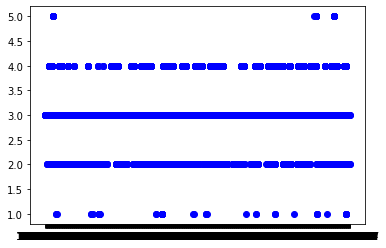

In [5]:
plt.plot(data.date_release, data["max.danger.corr"], 'bo')
plt.show()

Как видим, очень редко лавинная опасность достигает максимальной отметки в 5 баллов. Также не очень часто 1 балл.

<AxesSubplot:xlabel='max.danger.corr', ylabel='count'>

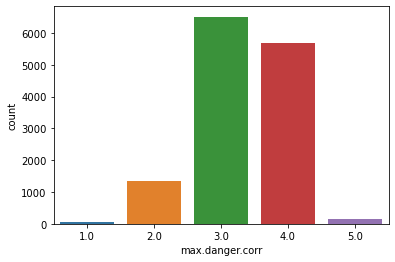

In [6]:
sns.countplot(x="max.danger.corr", data=data)

In [7]:
data["max.danger.corr"].value_counts()

3.0    6510
4.0    5686
2.0    1332
5.0     165
1.0      52
Name: max.danger.corr, dtype: int64

Как видим, доля показаний с оценкой 3 и 4 сильно превосходит все остальные вместе взятые. То есть, появляется проблема несбалансированных классов. Когда классы сильно отличаются по количеству примеров, это плохо сказывается на качестве работы классификатора. Например, достаточно случайным образом выдавать оценки 3 и 4, чтобы получить точность близкую к 90%.

# Попробуем слить записи за сутки в одну запись. Откинув все остальные колонки, кроме даты и оценки опасности.

In [8]:
unique_dates = pd.DataFrame(data.date_release.unique(), columns=['date_release'])

In [9]:
data_danger = data.drop(columns=["snow_type", "trigger_type", "aval_size_class", "weight_AAI"])

In [10]:
data_danger['full_string'] = data_danger['date_release'] + data_danger['max.danger.corr'].astype(str)

In [11]:
data_danger.index = data_danger['full_string']

In [12]:
days_danger = pd.DataFrame(data_danger.full_string.unique(), columns = ['full_string'])

In [13]:
days_danger['date'] = days_danger["full_string"].map(lambda x: x[:10])
days_danger['danger'] = days_danger['full_string'].map(lambda x: x[10:])

In [14]:
days_danger = days_danger.drop(columns=['full_string'])

In [15]:
days_danger = days_danger[days_danger['danger']!='nan']

In [16]:
days_danger = days_danger.reset_index()

In [17]:
days_danger = days_danger.drop(columns=['index'])

In [18]:
days_danger['danger'] = days_danger['danger'].astype(float)

In [19]:
days_danger['danger'] = days_danger['danger'].astype(int)

In [26]:
days_danger.date = days_danger.date.map(lambda x: str(x[0:4]) + str(x[5:7]) + str(x[8:10]))

In [42]:
days_danger.tail()

,date,danger
1323,20190420,3
1324,20190421,3
1325,20190423,2
1326,20190424,3
1327,20190507,2


Найдём и удалим записи с двумя датами. Это дни, когда лавинная опасность менялась в течение дня.

In [35]:
double_dates = dict()

In [38]:
for date in days_danger.date:
    if date in double_dates.keys():
        double_dates.update({date : double_dates.get(date) + 1})
    else:
        double_dates.update({date : 0})

In [43]:
dates_to_drop = []
for key, val in double_dates.items():
    if val != 0:
        dates_to_drop.append(key)

In [44]:
dates_to_drop

['20171211',
 '20171212',
 '20180105',
 '20180106',
 '20180121',
 '20180122',
 '20180123',
 '20180124',
 '20180212',
 '20180213',
 '20180215',
 '20180404',
 '20180405',
 '20190114',
 '20190115',
 '20190116',
 '20190218',
 '20190219',
 '20190227',
 '20190228',
 '20190315',
 '20190316',
 '20190417']

In [50]:
for date in dates_to_drop:
    print(days_danger[days_danger.date == date])

          date  danger
1124  20171211       4
1125  20171211       3
          date  danger
1126  20171212       4
1127  20171212       3
          date  danger
1142  20180105       4
1143  20180105       5
          date  danger
1144  20180106       4
1145  20180106       3
          date  danger
1151  20180121       3
1152  20180121       4
          date  danger
1153  20180122       4
1154  20180122       5
          date  danger
1155  20180123       5
1156  20180123       4
1157  20180123       2
          date  danger
1158  20180124       4
1159  20180124       3
          date  danger
1164  20180212       1
1165  20180212       3
          date  danger
1166  20180213       3
1167  20180213       1
1168  20180213       2
          date  danger
1170  20180215       3
1171  20180215       2
          date  danger
1199  20180404       2
1200  20180404       3
          date  danger
1201  20180405       2
1202  20180405       3
          date  danger
1246  20190114       5
1247  20190

Все такие дни были зимой 17-18 и 18-19. Так как их немного, то просто от них избавимся.

In [53]:
days_danger = days_danger[~days_danger.date.isin(dates_to_drop)]

In [55]:
days_danger = days_danger.reset_index()

In [57]:
days_danger = days_danger.drop(columns=['index'])

In [58]:
days_danger

,date,danger
0,19981207,3
1,19981208,3
2,19981210,3
3,19981211,3
4,19981212,3
5,19981213,3
6,19981214,3
7,19981215,3
8,19981216,2
9,19981217,2


Этот датасет готов. Осталось его сохранить.

In [59]:
days_danger.to_csv('dates_danger.csv', index=False)